In [ ]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

In [1]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images

all_images = convert_pdfs_to_images("./data/")

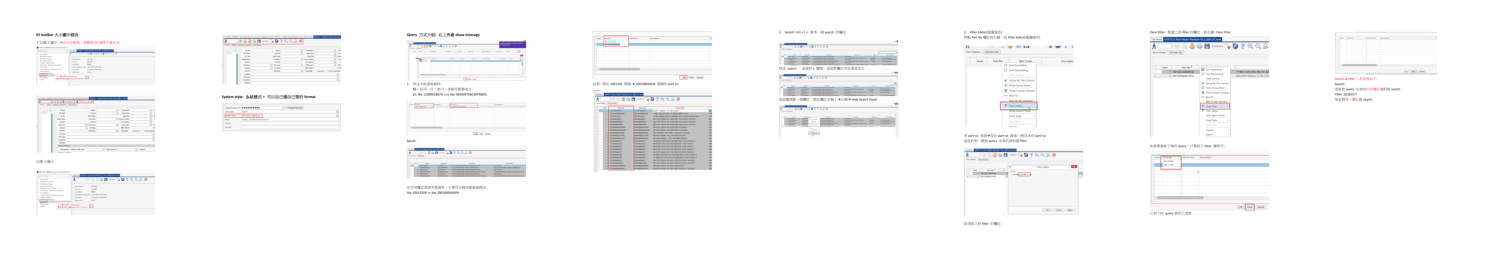

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

/home/user/anaconda3/envs/colpali/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: data/ARCMIS_v5_Operation_Manual.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: data/IT_help_desk.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of document 1 to index.
Added page 6 of document 1 to index.
Added page 7 of document 1 to index.
Added page 8 of 

{0: 'data/ARCMIS_v5_Operation_Manual.pdf', 1: 'data/IT_help_desk.pdf'}

In [5]:
text_query = "如果Order Ack裡沒有資料，該怎麼辦?"

results = docs_retrieval_model.search(text_query, k=3)
results

[{'doc_id': 1, 'page_num': 1, 'score': 12.75, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 2, 'score': 9.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 1, 'score': 9.875, 'metadata': {}, 'base64': None}]

In [6]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result['doc_id']
        page_num = result['page_num']
        grouped_images.append(all_images[doc_id][page_num - 1]) # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images

grouped_images = get_grouped_images(results, all_images)

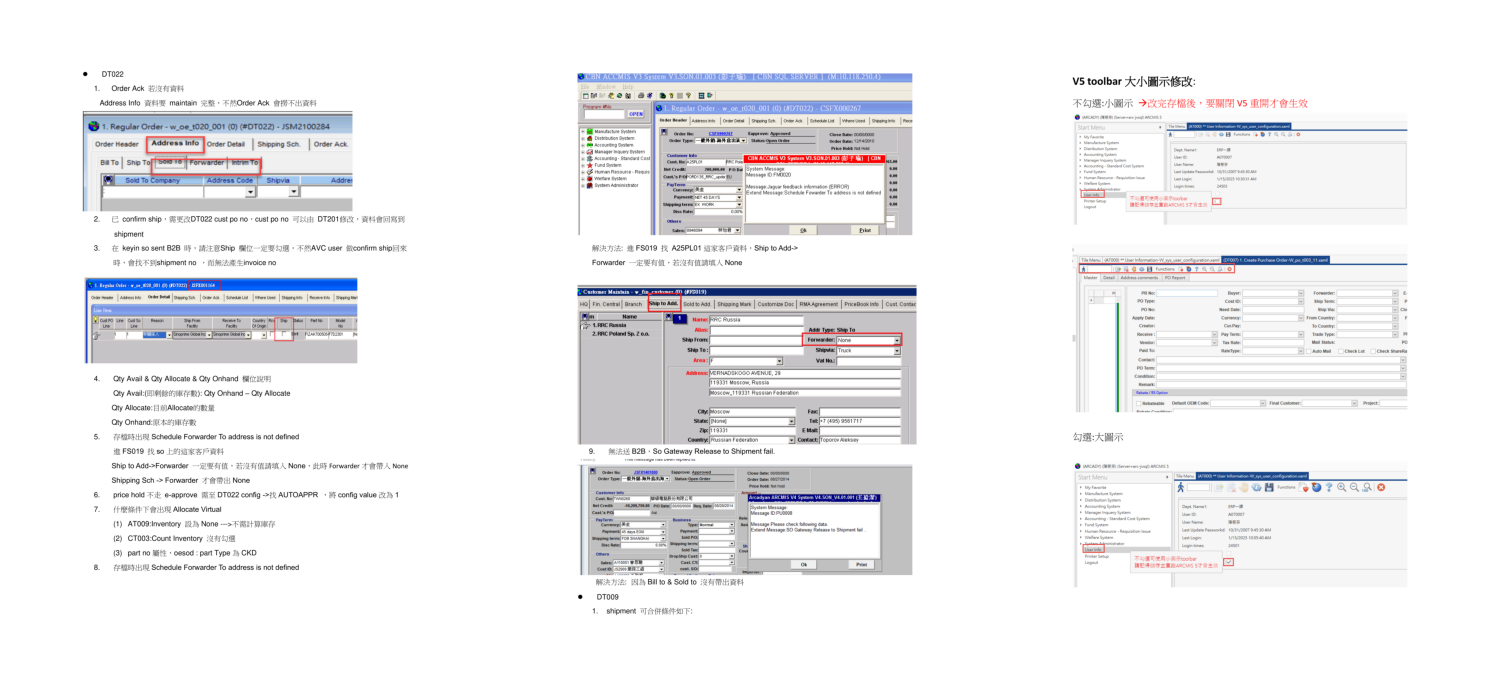

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from transformers import Qwen3VLForConditionalGeneration, Qwen3VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen3VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen3-VL-4B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 81.43it/s]


Qwen3VLForConditionalGeneration(
  (model): Qwen3VLModel(
    (visual): Qwen3VLVisionModel(
      (patch_embed): Qwen3VLVisionPatchEmbed(
        (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (pos_embed): Embedding(2304, 1024)
      (rotary_pos_emb): Qwen3VLVisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-23): 24 x Qwen3VLVisionBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Qwen3VLVisionAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (mlp): Qwen3VLVisionMLP(
            (linear_fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (linear_fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (act_fn): GELUTanh()
          )
        )
      )
 

In [9]:
min_pixels = 224*224
max_pixels = 1024*1024
vl_model_processor = Qwen3VLProcessor.from_pretrained(
    "Qwen/Qwen3-VL-4B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

In [10]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": grouped_images[0],
            },
            {
                "type": "image",
                "image": grouped_images[1],
            },
            {
                "type": "image",
                "image": grouped_images[2],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

In [11]:
text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

In [12]:
image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [14]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

In [15]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [16]:
print(output_text[0])

根據圖片1中的說明，如果Order Ack裡沒有資料，原因在於「Address Info 資料要 maintain 完整，不然Order Ack 會撈不出資料」。因此，解決方法是確保在Order Header頁面的「Address Info」區塊內，所有必要的資料（例如：Ship To、Sold To、Forwarder、Intrm To等）都已完整填寫。圖中紅框標示的「Address Info」區域即是需要檢查的重點。若資料不完整，系統將無法產生Order Ack。


In [17]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image", "image": image} for image in grouped_images
            ] + [
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

In [ ]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="How do I assemble the Micke desk?",
    top_k=3,
    max_new_tokens=500
)
print(output_text[0])